Study local 3D scale of neurons in Torus Semicircularis (TS) of Larval zebrafish.

# Packages importation and general configuration

In [1]:
import sys
import glob
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import measure

import nrrd

from scipy import stats
from scipy import interpolate
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d

from matplotlib import cm
from matplotlib.colors import ListedColormap

sys.setrecursionlimit(10**7)

In [2]:
from genepy3d.io import swc
from genepy3d.obj import curves, trees, points, surfaces
from genepy3d.util import geo, plot as mypl

In [3]:
%matplotlib notebook

# Setting scale range

The maximal scale (rmax) is defined based on the length of the longest branch in dataset (i.e; rmax = 1/3 * 225 microns).

In [4]:
rmin, rmax = 1, 177
r_lst = np.arange(rmin,rmax,5)
print("list of scales:",r_lst)

list of scales: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176]


# importing neuronal traces from SWC files

In [5]:
filepath = "../data/zebrafish/complete_dataset/Original/"
f = swc.SWC(filepath,recursive=True)

neuidlst = np.load("../data/zebrafish/torus_neuid.npy")
print("nb. of imported neurons:",len(neuidlst))
print(neuidlst)

nb. of imported neurons: 141
[   0    8   39   43   57   66   70   79   87  122  128  132  149  161
  173  174  191  193  210  242  248  251  261  280  281  316  325  329
  330  369  374  435  436  437  455  471  487  526  540  552  583  601
  664  668  669  672  743  777  778  781  786  795  809  812  819  844
  846  882  883  900  901  905  910  934  953  961  971  977  979  980
  988  991 1006 1034 1041 1062 1090 1094 1146 1169 1180 1186 1190 1217
 1219 1225 1244 1252 1261 1305 1306 1312 1328 1329 1341 1359 1384 1392
 1396 1397 1410 1424 1437 1455 1490 1503 1505 1510 1511 1522 1555 1583
 1594 1655 1690 1691 1693 1701 1717 1727 1728 1751 1754 1758 1770 1772
 1779 1788 1791 1818 1819 1830 1841 1844 1872 1882 1885 1923 1929 1935
 1936]


# Loading brain regions

In [6]:
regions, _ = nrrd.read('../data/zebrafish/MPIN-Atlas__brain_region__Combined_brain_regions/MPIN-Atlas__brain_region__Combined_brain_regions.nrrd')
regions = np.swapaxes(regions,0,2)

In [7]:
print('shape (Z, Y, X):',regions.shape)

shape (Z, Y, X): (359, 974, 597)


In [8]:
maxlbl = np.max(regions)
clcs = np.random.rand(maxlbl,3)
print('max region id:',maxlbl)

max region id: 36


# Loading region label csv

In [9]:
region_csv = pd.read_csv("../data/zebrafish/MPIN-Atlas__brain_region__Combined_brain_regions/MPIN-Atlas__brain_region__Combined_brain_regions_index_refined.csv")
region_csv.head()

Grey_level                  Brain_region  norm_strength  Abbr
0           1  Medial_octavolateral_nucleus      22.454680   MON
1           2                    Cerebellum      38.791980    Cb
2           3                   MO_stripe_1      26.976780  MOS1
3           4                   MO_stripe_2       0.291515  MOS2
4           5                   MO_stripe_3      14.606526  MOS3

# Customizing scale color map

<IPython.core.display.Javascript object>


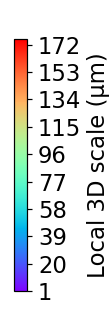

In [10]:
# custom colorbar
mycmp = cm.get_cmap('rainbow')
fig, ax = plt.subplots(figsize=(1, 3))
fig.subplots_adjust(right=0.25)

norm = mpl.colors.Normalize(vmin=int(r_lst.min()), vmax=int(r_lst.max()))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mycmp,
                                norm=norm,
                                orientation='vertical')

cb1.set_ticks(range(int(r_lst.min()),int(r_lst.max())+1,19));
ax.set_yticklabels(cb1.get_ticks(),fontsize=15);
cb1.set_label('Local 3D scale (µm)',fontsize=15);

# Local 3D scales in TS

## All neurons arriving to TS

<IPython.core.display.Javascript object>


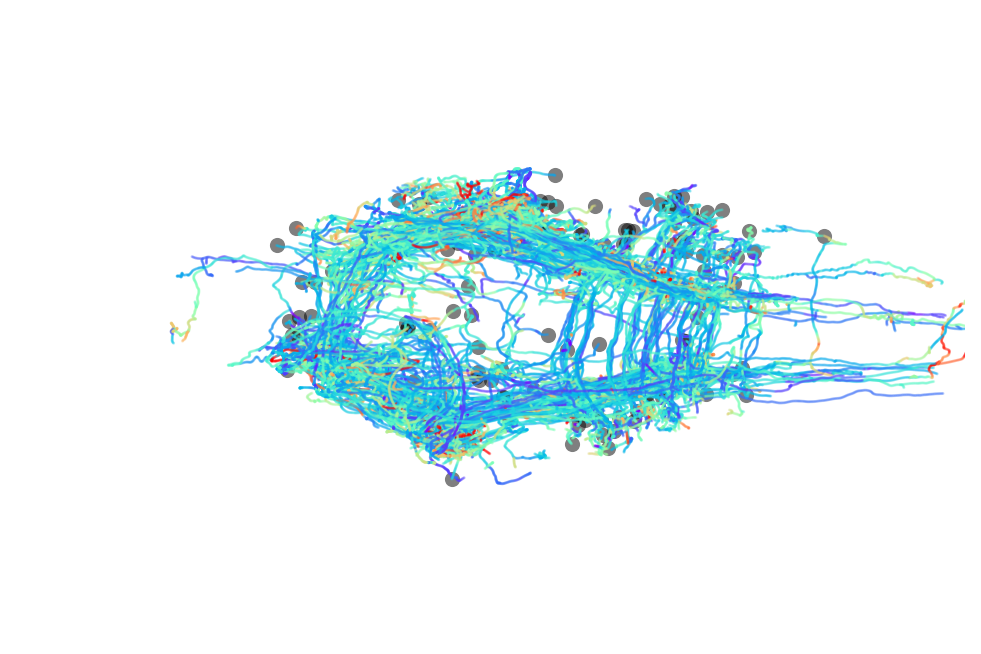

In [11]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
left_neuidlst = []
step_size = 10

ls_region = []
root_reg_lst = []

lenlst = []

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    
    lenlst.append(neuron.compute_length(neuron.compute_spine()))
    
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    root_reg_lst.append(root_reg_lbl)

    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    
    meandf = subdf.groupby("nodeid")["local_scale"].mean()

    lstmp = meandf.values.flatten()
    lstmp[lstmp>r_lst[-1]]=r_lst[-1]
    
    coors = neuron.get_coordinates(meandf.index.values).values
    coors_int = coors.astype(np.int)
    coors_reg_lbl = regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]
    ix = np.argwhere(coors_reg_lbl==33).flatten()
    ls_region += lstmp[ix].tolist()
#     ls_region.append(np.mean(lstmp[ix]))

    coors = neuron.get_coordinates(meandf.index.values).values
    xcoors = xcoors + coors[:,0].tolist()
    ycoors = ycoors + coors[:,1].tolist()
    zcoors = zcoors + coors[:,2].tolist()

    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=lstmp,
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)

    ax.plot(rootcoors[:,0],
        rootcoors[:,1],
        rootcoors[:,2],'o',
        c="black",ms=10,markeredgewidth=0.,alpha=0.5)

# plot isosurfaces
# step_size = 1
# surf = surfaces.Surface.from_volume(regions,level=33,spacing=(1,1,1),step_size=step_size)
# surf.plot(ax,args_3d={'color':"gray",'alpha':0.2,"zorder":10000});

para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=9,elev=72)
ax.dist = 6
ax.axis("off");
        
plt.tight_layout();

<IPython.core.display.Javascript object>


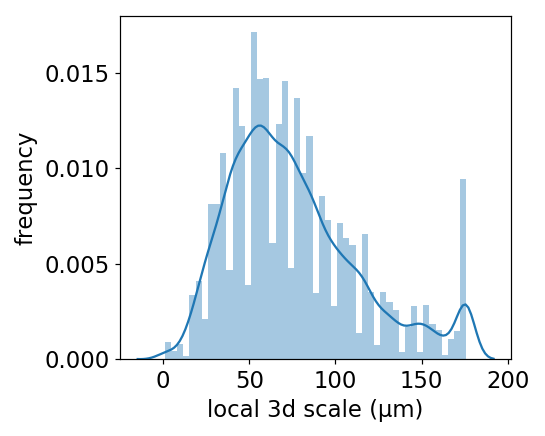

In [12]:
# local scale histogram
siz = 15
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
sns.distplot(ls_region)
ax.set_xlabel("local 3d scale (µm)",fontsize=siz);
ax.set_ylabel("frequency",fontsize=siz);
plt.tight_layout();
ax.tick_params(labelsize=siz)
plt.tight_layout();

## Which regions they come from?

In [13]:
reg_ix = np.unique(root_reg_lst)
reg_count = []
for ix in reg_ix:
    reg_count.append(len(np.argwhere(root_reg_lst==ix).flatten()))

<IPython.core.display.Javascript object>


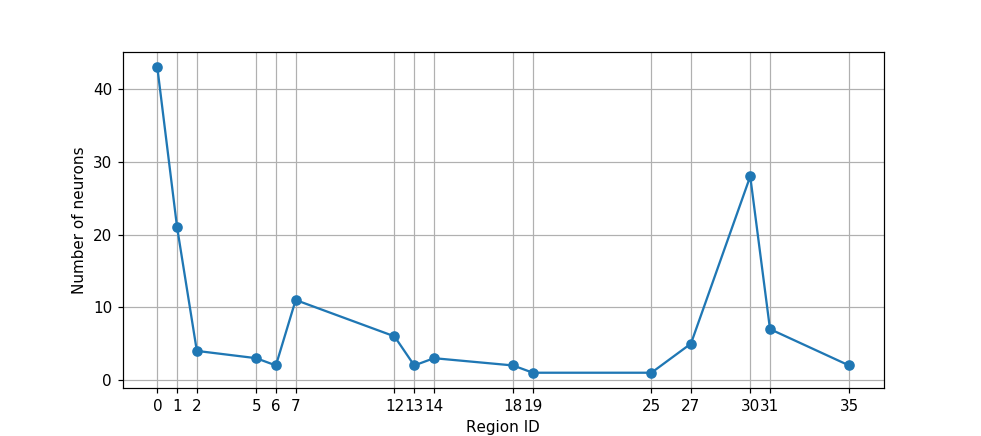

In [14]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)
ax.plot(reg_ix,reg_count,'-o');
ax.set_xticks(reg_ix);
ax.set_xlabel("Region ID");
ax.set_ylabel("Number of neurons");
ax.grid("on")

### Export to csv

In [15]:
brain_region = region_csv.set_index("Grey_level").loc[reg_ix]["Brain_region"].values
abbr = region_csv.set_index("Grey_level").loc[reg_ix]["Abbr"].values
tsregcount = pd.DataFrame({"Index":reg_ix,"Name":brain_region,"Abbr":abbr,"Number":reg_count})

In [16]:
tsregcount

Index                              Name  Abbr  Number
0       0                               NaN   NaN      43
1       1      Medial_octavolateral_nucleus   MON      21
2       2                        Cerebellum    Cb       4
3       5                       MO_stripe_3  MOS3       3
4       6                       MO_stripe_4  MOS4       2
5       7                       MO_stripe_5  MOS5      11
6      12                         Tegmentum     T       6
7      13      anterior_reticular_formation   aRF       2
8      14  intermediate_reticular_formation  imRF       3
9      18         intermediate_hypothalamus    Hi       2
10     19              rostral_hypothalamus    Hr       1
11     25              Posterior_teberculum    PT       1
12     27                         pretectum   PrT       5
13     30                            tectum   TeO      28
14     31                          Thalamus    Th       7
15     35                      Vagal_region    VR       2

## Tectum

<IPython.core.display.Javascript object>


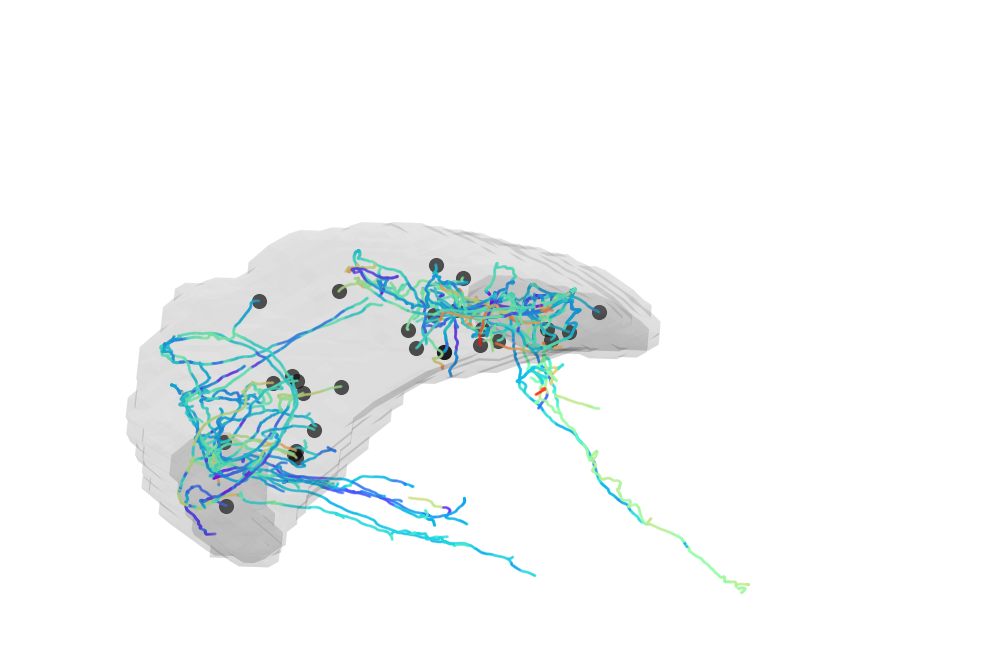

In [17]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
ls_region_begin, ls_region_end = [], []

target_region = 30

ite, ref = 0,10

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    if root_reg_lbl == target_region:
        
    #     if (rootcoors[:,1]<350)&(rootcoors[:,0]<270):
#         if (rootcoors[:,0]>270):
#         ite += 1
#         if ite == ref:

        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()

        lstmp = meandf.values.flatten()
        lstmp[lstmp>r_lst[-1]]=r_lst[-1]
        coors = neuron.get_coordinates(meandf.index.values).values
        coors_int = coors.astype(np.int)
        coors_reg_lbl = regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]
        
        ix = np.argwhere(coors_reg_lbl==target_region).flatten()
        ls_region_begin += lstmp[ix].tolist()
        
        ix = np.argwhere(coors_reg_lbl==33).flatten()
        ls_region_end += lstmp[ix].tolist()
#         ls_region_end.append(np.mean(lstmp[ix]))

        xcoors = xcoors + coors[ix,0].tolist()
        ycoors = ycoors + coors[ix,1].tolist()
        zcoors = zcoors + coors[ix,2].tolist()

        pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=lstmp,
                        s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.5)

        ax.plot(rootcoors[:,0],
            rootcoors[:,1],
            rootcoors[:,2],'o',
            c="black",ms=10,markeredgewidth=0.,alpha=0.7)

#             break

# plot isosurfaces
step_size = 10
surf = surfaces.Surface.from_volume(regions,lbl=33,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=target_region,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
    
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=48,elev=75)
ax.axis("off");
        
plt.tight_layout();

ls_region_end1 = np.copy(ls_region_end)

### Only for axons coming from one side of hemisphere

<IPython.core.display.Javascript object>


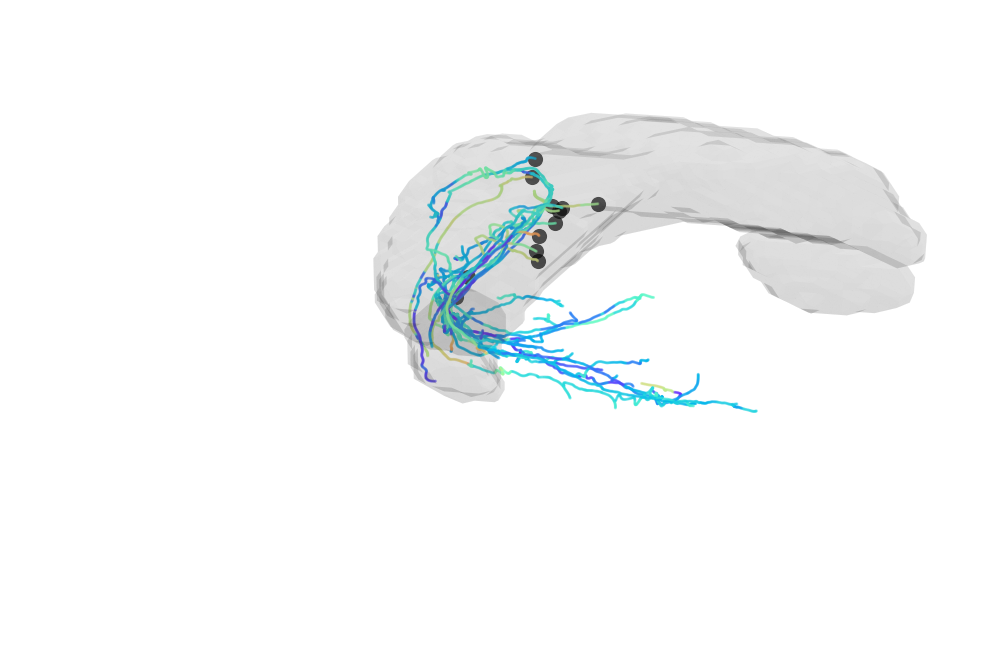

In [19]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
ls_region_begin, ls_region_end = [], []

target_region = 30

ite, ref = 0,10

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    if (root_reg_lbl == target_region)&(root_coors_int[0]>=275):
        
    #     if (rootcoors[:,1]<350)&(rootcoors[:,0]<270):
#         if (rootcoors[:,0]>270):
#         ite += 1
#         if ite == ref:

        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()

        lstmp = meandf.values.flatten()
        lstmp[lstmp>r_lst[-1]]=r_lst[-1]
        coors = neuron.get_coordinates(meandf.index.values).values
        coors_int = coors.astype(np.int)
        coors_reg_lbl = regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]
        
        ix = np.argwhere(coors_reg_lbl==target_region).flatten()
        ls_region_begin += lstmp[ix].tolist()
        
        ix = np.argwhere(coors_reg_lbl==33).flatten()
        ls_region_end += lstmp[ix].tolist()

        xcoors = xcoors + coors[:,0].tolist()
        ycoors = ycoors + coors[:,1].tolist()
        zcoors = zcoors + coors[:,2].tolist()

        pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=lstmp,
                        s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.5)

        ax.plot(rootcoors[:,0],
            rootcoors[:,1],
            rootcoors[:,2],'o',
            c="black",ms=10,markeredgewidth=0.,alpha=0.7)

#             break

# plot isosurfaces
step_size = 10
surf = surfaces.Surface.from_volume(regions,lbl=33,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=target_region,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
    
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=57,elev=32)
# ax.view_init(azim=48,elev=75)
ax.axis("off");
        
plt.tight_layout();

### Histogram

<IPython.core.display.Javascript object>


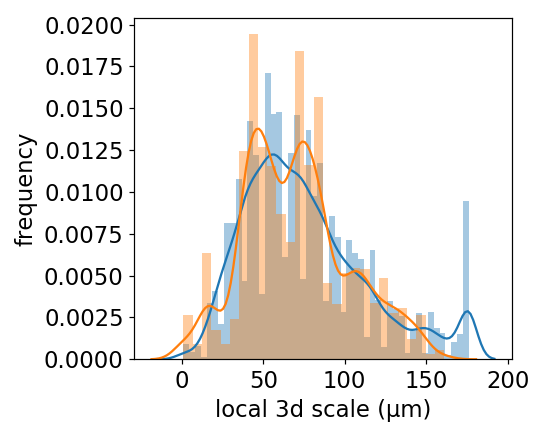

In [20]:
siz = 15
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
sns.distplot(ls_region)
sns.distplot(ls_region_end1);
ax.set_xlabel("local 3d scale (µm)",fontsize=siz);
ax.set_ylabel("frequency",fontsize=siz);
plt.tight_layout();
ax.set_xticklabels(ax.get_xticklabels(),fontsize=siz);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=siz);
plt.tight_layout();

## MON/MOS

<IPython.core.display.Javascript object>


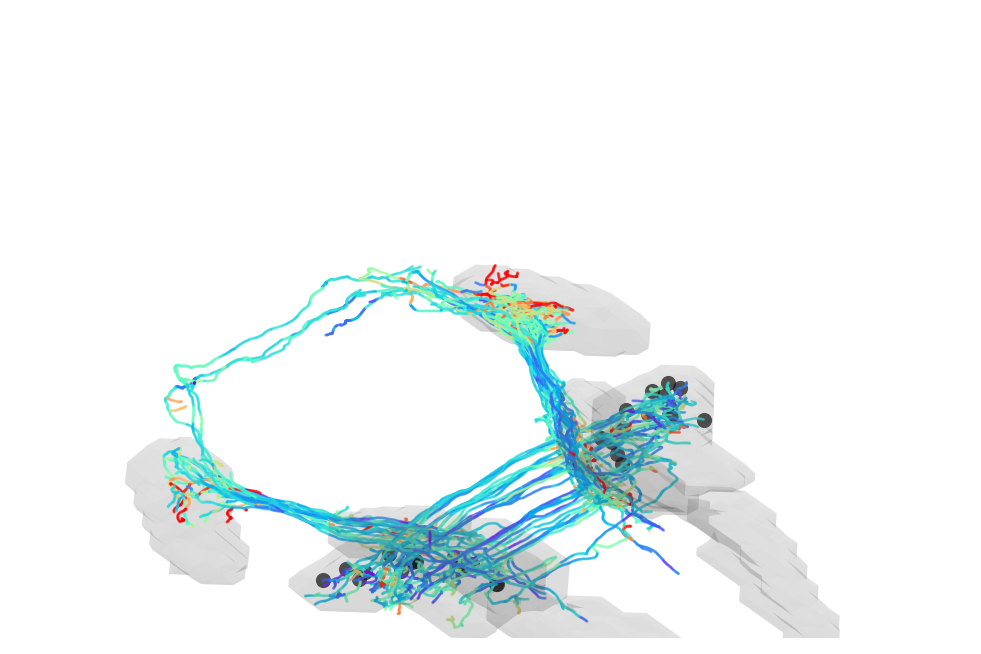

In [21]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
ls_region_begin, ls_region_end2 = [], []

target_region = 1

ite, ref = 0,10

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    if (root_reg_lbl == 1) | (root_reg_lbl == 7):
        
    #     if (rootcoors[:,1]<350)&(rootcoors[:,0]<270):
#         if (rootcoors[:,0]>270):
#         ite += 1
#         if ite == ref:

        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()

        lstmp = meandf.values.flatten()
        lstmp[lstmp>r_lst[-1]]=r_lst[-1]
        coors = neuron.get_coordinates(meandf.index.values).values
        coors_int = coors.astype(np.int)
        coors_reg_lbl = regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]
        
        ix = np.argwhere(coors_reg_lbl==target_region).flatten()
        ls_region_begin += lstmp[ix].tolist()
        
        ix = np.argwhere(coors_reg_lbl==33).flatten()
        ls_region_end += lstmp[ix].tolist()
#         ls_region_end.append(np.mean(lstmp[ix]))

        xcoors = xcoors + coors[ix,0].tolist()
        ycoors = ycoors + coors[ix,1].tolist()
        zcoors = zcoors + coors[ix,2].tolist()

        pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=lstmp,
                        s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.5)
        ax.plot(rootcoors[:,0],
            rootcoors[:,1],
            rootcoors[:,2],'o',
            c="black",ms=10,markeredgewidth=0.,alpha=0.7)

#             break

# plot isosurfaces
step_size = 10
surf = surfaces.Surface.from_volume(regions,lbl=33,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=1,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=7,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
    
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
# ax.view_init(azim=9,elev=72)
ax.view_init(azim=48,elev=75)
ax.axis("off");
        
plt.tight_layout();

ls_region_end2 = np.copy(ls_region_end)

### Only for axons coming from one side of hemisphere

<IPython.core.display.Javascript object>


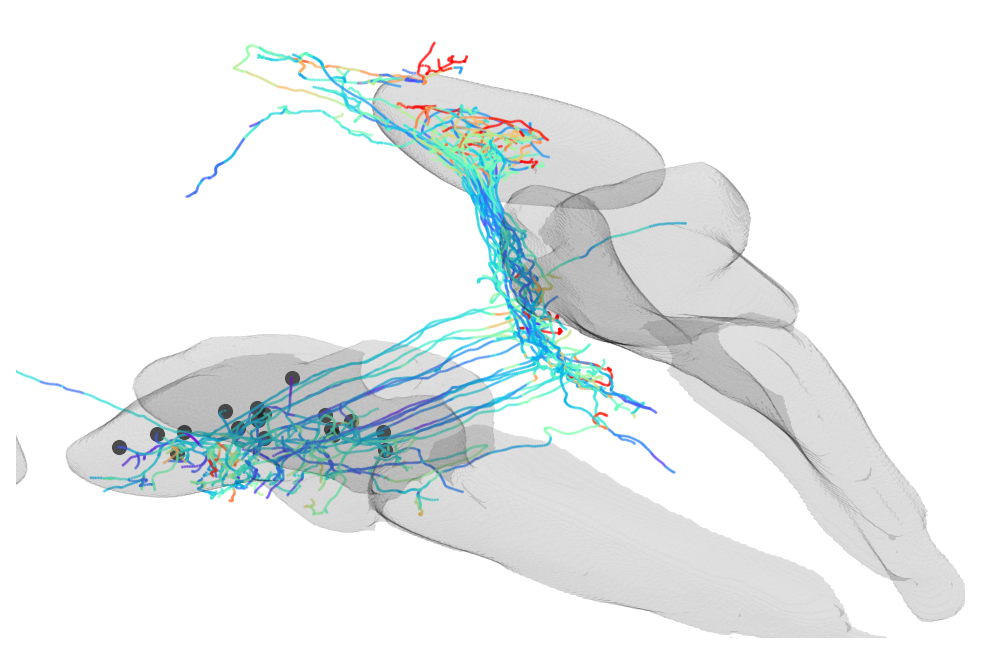

In [22]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
ls_region_begin, ls_region_end = [], []

target_region = 1

ite, ref = 0,10

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    if ((root_reg_lbl == 1) | (root_reg_lbl == 7))&(root_coors_int[0]>=275):
        
    #     if (rootcoors[:,1]<350)&(rootcoors[:,0]<270):
#         if (rootcoors[:,0]>270):
#         ite += 1
#         if ite == ref:

        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()

        lstmp = meandf.values.flatten()
        lstmp[lstmp>r_lst[-1]]=r_lst[-1]
        coors = neuron.get_coordinates(meandf.index.values).values
        coors_int = coors.astype(np.int)
        coors_reg_lbl = regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]
        
        ix = np.argwhere(coors_reg_lbl==target_region).flatten()
        ls_region_begin += lstmp[ix].tolist()
        
        ix = np.argwhere(coors_reg_lbl==33).flatten()
        ls_region_end += lstmp[ix].tolist()

        xcoors = xcoors + coors[:,0].tolist()
        ycoors = ycoors + coors[:,1].tolist()
        zcoors = zcoors + coors[:,2].tolist()

        pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=lstmp,
                        s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.5)

        ax.plot(rootcoors[:,0],
            rootcoors[:,1],
            rootcoors[:,2],'o',
            c="black",ms=10,markeredgewidth=0.,alpha=0.7)

#             break

# plot isosurfaces
step_size = 10
surf = surfaces.Surface.from_volume(regions,lbl=33,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=1,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=7,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
    
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=51,elev=62)
ax.dist = 6
ax.axis("off");
        
plt.tight_layout();

### Histogram

<IPython.core.display.Javascript object>


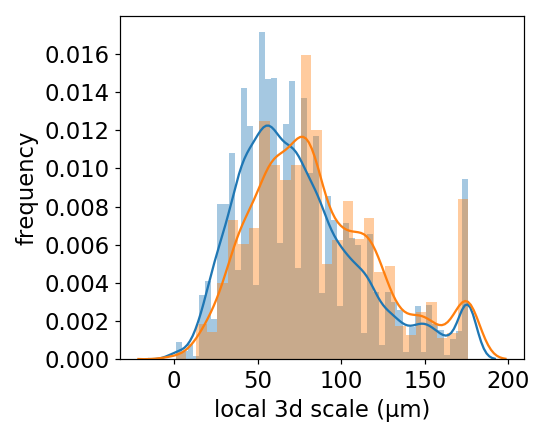

In [23]:
siz = 15
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
sns.distplot(ls_region)
sns.distplot(ls_region_end2);
ax.set_xlabel("local 3d scale (µm)",fontsize=siz);
ax.set_ylabel("frequency",fontsize=siz);
plt.tight_layout();
ax.set_xticklabels(ax.get_xticklabels(),fontsize=siz);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=siz);
plt.tight_layout();

## Statistical tests

In [24]:
ls_test = [ls_region,ls_region_end1,ls_region_end2,ls_region]
pvallst = []
for i in range(len(ls_test)-1):
    item1 = ls_test[i]
    item2 = ls_test[i+1]
    _, pval = stats.ttest_ind(item1,item2)
    pvallst.append(pval)
    
multipletests(pvallst,method="holm-sidak")

(array([ True,  True,  True]),
 array([2.86659585e-13, 0.00000000e+00, 0.00000000e+00]),
 0.016952427508441503,
 0.016666666666666666)

## Local 3D scale along a neuronal trace

### An illustration

<IPython.core.display.Javascript object>


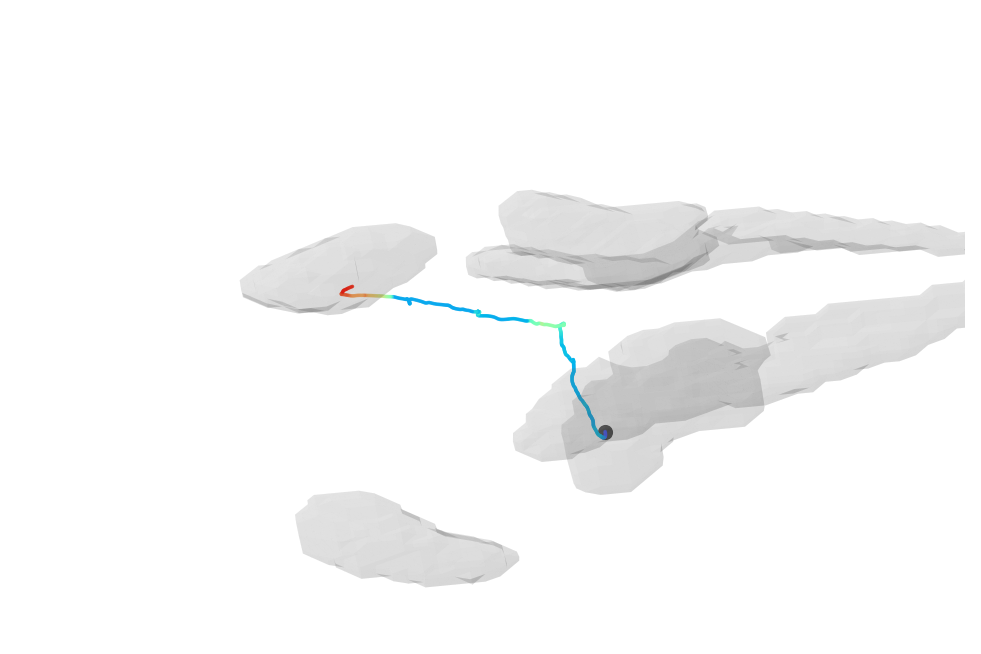

In [25]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
ite, ref = 0,10
good_neu_reg = []
tuples = []

# for neuid in neuidlst:
for neuid in [1923]:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
#     if (rootcoors[:,1]>500)&(rootcoors[:,0]>300):
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]

    if (root_reg_lbl == 7)| (root_reg_lbl == 1):

        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()

        spinenodes = neuron.compute_spine()
        meandf = meandf.loc[spinenodes]

        coors = neuron.get_coordinates(meandf.index.values).values
        coors_int = coors.astype(np.int)
        if len(np.argwhere(regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]==33).flatten())!=0:
            
#             ite += 1
#             if ite==ref:

            good_neu_reg.append(neuid)
            
            xcoors = xcoors + coors[:,0].tolist()
            ycoors = ycoors + coors[:,1].tolist()
            zcoors = zcoors + coors[:,2].tolist()
            
            lastix = np.argwhere(measure.label(regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]==33)==1).flatten()[-1]
            
            tuples.append(np.append(coors[:lastix+1],meandf.values.flatten()[:lastix+1,np.newaxis],axis=1))

            pl = ax.scatter(coors[:lastix+1,0],coors[:lastix+1,1],coors[:lastix+1,2],c=meandf.values.flatten()[:lastix+1],
                            s=2,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.8)

            ax.plot(rootcoors[:,0],
                rootcoors[:,1],
                rootcoors[:,2],'o',
                c="black",ms=10,markeredgewidth=0.,alpha=0.7)
                
#                 break

# plot isosurfaces
step_size = 10
surf = surfaces.Surface.from_volume(regions,lbl=33,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=7,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
surf = surfaces.Surface.from_volume(regions,lbl=1,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
    
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=-9,elev=63)
ax.dist = 14
ax.axis("off");
        
plt.tight_layout();

### Computing local 3D scales along axonal traces

In [28]:
xcoors, ycoors, zcoors = [], [], []
ite, ref = 0,10
good_neu_reg = []
tuples = []

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]

    if (root_reg_lbl == 7)| (root_reg_lbl == 1):

        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()

        spinenodes = neuron.compute_spine()
        meandf = meandf.loc[spinenodes]

        coors = neuron.get_coordinates(meandf.index.values).values
        coors_int = coors.astype(np.int)
        if len(np.argwhere(regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]==33).flatten())!=0:

            good_neu_reg.append(neuid)
            
            xcoors = xcoors + coors[:,0].tolist()
            ycoors = ycoors + coors[:,1].tolist()
            zcoors = zcoors + coors[:,2].tolist()
            
            lastix = np.argwhere(measure.label(regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]==33)==1).flatten()[-1]
            
            tuples.append(np.append(coors[:lastix+1],meandf.values.flatten()[:lastix+1,np.newaxis],axis=1))


In [29]:
t_lst, ls_lst = [], []
for tup in tuples:
    coefcoors, to = interpolate.splprep(tup[:,:3].T.tolist(),k=1,s=0)
    coefls = interpolate.splrep(to,tup[:,3],k=1,s=0)
    tn = np.arange(0,1.01,0.01)
    lsn = interpolate.splev(tn,coefls)
    t_lst += tn.tolist()
    ls_lst += lsn.tolist()
    
tmpdf = pd.DataFrame({"time_point":t_lst,"local_3d_scale":ls_lst})

<IPython.core.display.Javascript object>


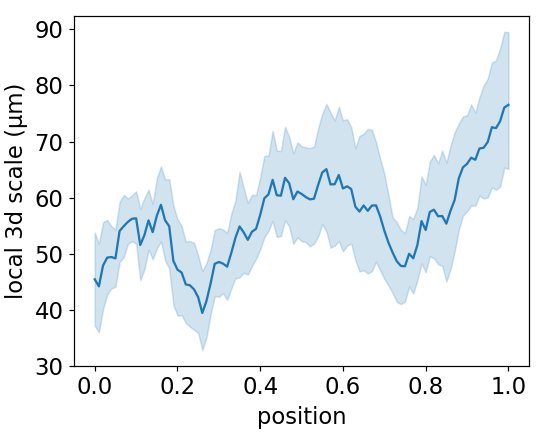

In [30]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
sns.lineplot(x="time_point", y="local_3d_scale", data=tmpdf);
ax.set_xlabel("position",fontsize=siz);
ax.set_ylabel("local 3d scale (µm)",fontsize=siz);
plt.tight_layout();
ax.set_xticklabels(ax.get_xticklabels(),fontsize=siz);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=siz);

## Same or Opposite sides

<IPython.core.display.Javascript object>


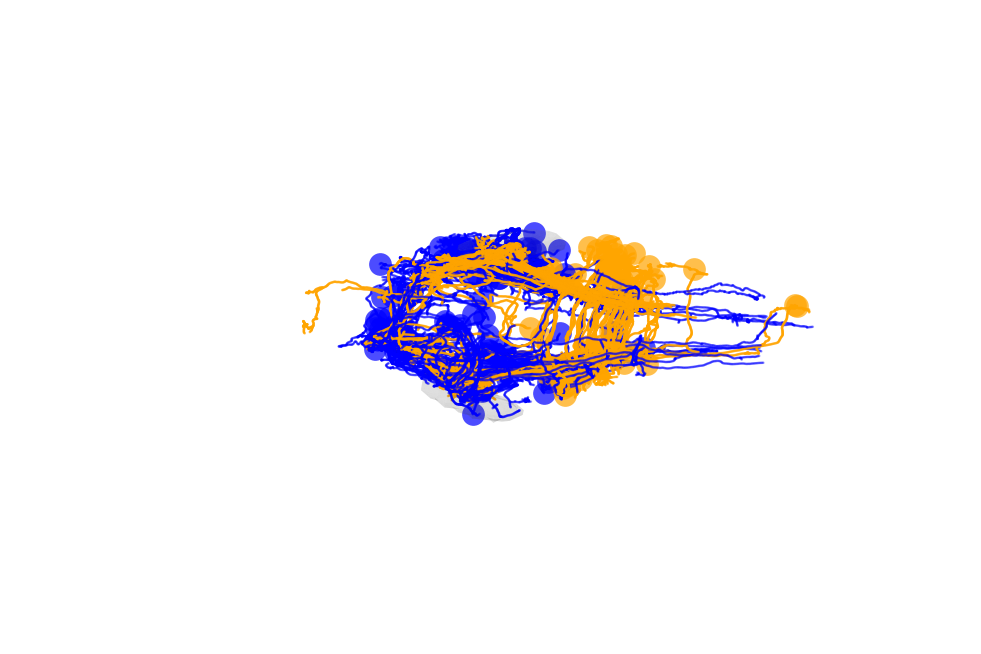

In [31]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
ls_region_same, ls_region_oppo = [], []

ite, ref = 0,10

for neuid in neuidlst:
    
    neuron = np.load("../data/zebrafish/torus_neurons/neuron_{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    root_side_flag = -1
    if (root_coors_int[0]>=270):
        root_side_flag = 1

    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]
    
    left_leaf_flag, right_leaf_flag = 0, 0
    leafix = np.argwhere(leaf_reg_lbl==33).flatten()
    for ix in leafix:
        if leaf_coors[ix,0]<270:
            left_leaf_flag = 1
        else:
            right_leaf_flag = 1
    if (left_leaf_flag > right_leaf_flag):
        leaf_side_flag = -1
    elif (left_leaf_flag < right_leaf_flag):
        leaf_side_flag = 1
    else:
        leaf_side_flag = 0
    
    df = pd.read_csv("../data/zebrafish/torus_neurons/neuron_{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].mean()
    lstmp = meandf.values.flatten()
    coors = neuron.get_coordinates(meandf.index.values).values
    coors_int = coors.astype(np.int)
    coors_reg_lbl = regions[coors_int[:,2],coors_int[:,1],coors_int[:,0]]
    ix = np.argwhere(coors_reg_lbl==33).flatten()
    
    if root_side_flag * leaf_side_flag > 0: # same side
        ls_region_same += lstmp[ix].tolist()
        pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c="blue",alpha=0.3,s=0.5)
        ax.plot(rootcoors[:,0],
            rootcoors[:,1],
            rootcoors[:,2],'bo',ms=15,markeredgewidth=0.,alpha=0.7)
    elif root_side_flag * leaf_side_flag < 0: # opposite side
        ls_region_oppo += lstmp[ix].tolist()
        pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c="orange",alpha=0.5,s=0.5)
        ax.plot(rootcoors[:,0],
            rootcoors[:,1],
            rootcoors[:,2],'o',c="orange",ms=15,markeredgewidth=0.,alpha=0.7)
        
    xcoors = xcoors + coors[:,0].tolist()
    ycoors = ycoors + coors[:,1].tolist()
    zcoors = zcoors + coors[:,2].tolist()

# plot isosurfaces
step_size = 10
surf = surfaces.Surface.from_volume(regions,lbl=33,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':"gray",'alpha':0.1});
    
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=9,elev=72)
ax.axis("off");
        
plt.tight_layout();

<IPython.core.display.Javascript object>


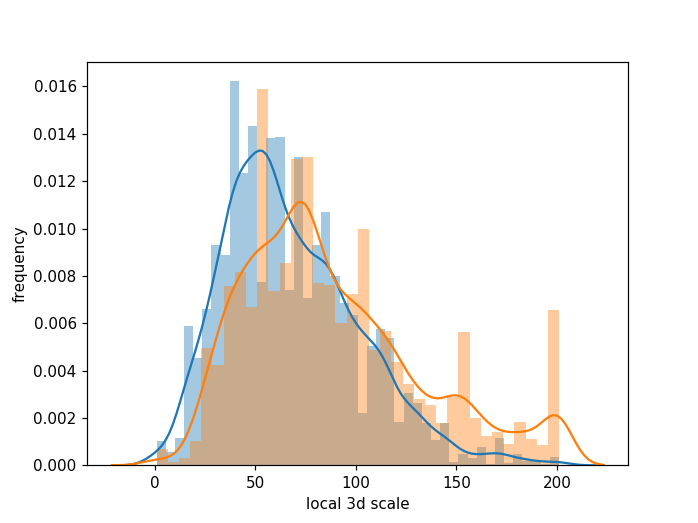

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.distplot(ls_region_same)
sns.distplot(ls_region_oppo)
ax.set_xlabel("local 3d scale");
ax.set_ylabel("frequency");